In [2]:
!pip install pybullet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 14.6 MB/s eta 0:00:00


# RL.py


In [19]:
import random
import numpy as np
import math

def reward_function(angle, velocity, angular_velocity):
    angular_velocity_degrees = math.degrees(angular_velocity)

    angle_weight = 2.5
    velocity_weight = 1.5
    angular_velocity_weight = 1

    target_all = 0

    angle_error = target_all - angle
    velocity_error = target_all - velocity
    angular_vel_error = target_all - angular_velocity_degrees

    factor_angle = 30
    factor_velocity = 2
    factor_angular_velocity = 115

    angle_reward = angle_weight * (1 - math.sqrt(abs(angle_error)) / math.sqrt(factor_angle))
    velocity_reward = velocity_weight * (1 - math.sqrt(abs(velocity_error)) / math.sqrt(factor_velocity))
    angular_velocity_reward = angular_velocity_weight * (1 - math.sqrt(abs( angular_vel_error)) / math.sqrt(factor_angular_velocity))

    angle_reward = max(angle_reward, 0)
    velocity_reward = max(velocity_reward, 0)
    angular_velocity_reward = max(angular_velocity_reward, 0)

    reward = angle_reward + velocity_reward + angular_velocity_reward

    return reward


# Genetic Algorithm
# It also has Microbial GA which I couldn't use

def genetic_algorithm_PID(args_list):
    population, pop_size, fitnesses_vector, search_space, mutation_rate = args_list

    index_parents = parents_selection(pop_size,  fitnesses_vector)
    parent_1 = population[index_parents[0]]
    parent_2 = population[index_parents[1]]
    daughter = crossover_PID(parent_1, parent_2)
    mutated_daughter = mutation_PID(daughter, search_space, mutation_rate)
    return mutated_daughter


def parents_selection(pop_size, fitnesses):
    ranked_fitness = np.argsort(fitnesses)
    wheel = np.cumsum(range(pop_size))
    max_wheel = np.sum(range(pop_size))

    pick_1 = np.random.rand() * max_wheel
    ind_1 = 0
    while pick_1 > wheel[ind_1]:
        ind_1 += 1

    pick_2 = np.random.rand() * max_wheel
    ind_2 = 0
    while pick_2 > wheel[ind_2]:
        ind_2 += 1

    index_1 = int(ranked_fitness[ind_1])
    index_2 = int(ranked_fitness[ind_2])

    return index_1, index_2


def crossover_PID(ind1, ind2):
    crossover_point = random.randint(1, len(ind1)-1)
    new_ind = np.concatenate([ind1[:crossover_point], ind2[crossover_point:]])
    return new_ind


def mutation_PID(ind, search_space, mutation_rate):
    for i in range(len(ind)):
        if random.random() < mutation_rate:
            mutation_amount = 0.1 * ind[i]
            ind[i] += mutation_amount if random.random() < 0.5 else -mutation_amount
    return ind


def fitnesses_PID(ind):
    cost = simulation_Adaptive_PID_Balancing(ind)
    return cost


# PID controller
def PID_output(kp, ki, kd, target_pitch, current_pitch, previous_error, integral_error, integral_max, integral_min, control_output_max, control_output_min):

    error = target_pitch - current_pitch
    derivative_error = error - previous_error
    integral_error += error

    if integral_error > integral_max:
        integral_error = integral_max
    elif integral_error < integral_min:
        integral_error = integral_min

    control_output = kp * error + ki * integral_error + kd * derivative_error
    control_output = max(min(control_output, control_output_max), control_output_min)
    previous_error = error

    return control_output, previous_error, integral_error


def init_population_PID(pop_size, search_space):
    kp_range, kd_range, ki_range = search_space
    return [init_individuals_PID(kp_range, kd_range, ki_range) for _ in range(pop_size)]


def init_individuals_PID(kp_range, kd_range, ki_range):
    kp = random.randint(kp_range[0], kp_range[1])  # Range for kp
    ki = random.uniform(ki_range[0], ki_range[1])  # Range for ki
    kd = random.uniform(kd_range[0], kd_range[1])   # Range for kd
    return [kp, kd, ki] # Notice that this returns a vector


def tournament_selection(population, fitnesses):
    P = len(population)
    index1 = random.randint(0, P-1)
    index2 = random.randint(0, P-1)

    P1 = population[index1]
    P2 = population[index2]

    if fitnesses[index1] > fitnesses[index2]:
        Winner = P1
        Loser = P2
    else:
        Winner = P2
        Loser = P1

    return Winner, Loser, index1, index2

# Simulation PID and environment (Horizontal Collision with object)

In [20]:
import pybullet as p
import pybullet_data
from collections import deque

# Obtaining position, linear velocity and angular velocity
def get_robot_state(robot_id):
    position, _ = p.getBasePositionAndOrientation(robot_id)
    velocity, angular_velocity = p.getBaseVelocity(robot_id)


    return position[0], velocity[0], angular_velocity[1]


def simulation_Adaptive_PID_Balancing(PID):
    # Pybullet configurations and environment
    p.connect(p.DIRECT)
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.setTimeStep(1./500.)
    p.setGravity(0, 0, -9.81)
    planeId = p.loadURDF("plane.urdf")

    # Scenario 4
    startPos = [0,0,-0.15]
    startOrientation = p.getQuaternionFromEuler([0,0,0]) # Position of the robot
    robot_id = p.loadURDF("/self_balancing_robot.urdf", startPos, startOrientation) # Upload robot
    start_time = time.time()
    object_added_2 = False
    flag= False

    # PID parameters
    control_output_max = 25 # Max value of PID (equal to max speed of motors rad/s)
    control_output_min = -25  # Min value of PID
    target_pitch = 0 # Setpoint of PID
    kp, ki, kd = PID
    integral_max = 100  # Against Wind Up
    integral_min = -100  # Against Wind Up
    integral_error = 0
    previous_error = 0

    # RL parameters
    time_sum = 0
    threshold_min = 30
    seconds = 15
    max_time = 500*seconds # Steps to finish episode if robot keeps inside the umbral range angle | 500 = 1 second
    total_reward = 0

    # Motor limitations
    max_torque = 3
    max_velocity =  21.68  # rad/s

    # Noise of sensor and delay of controller (steps)
    sensor_noise = 1.5
    delay_steps = 5
    control_output_buffer = deque(maxlen=delay_steps)

    start_time = time.time()

    while True:
        # Object appears and hits the robot after 5 secs -----------------------------------------------------
        current_time = time.time()
        elapsed_time = current_time - start_time

        if elapsed_time > 3 and not object_added_2 :
            # Object horizontally towards to the robot
            robot_position, _ = p.getBasePositionAndOrientation(robot_id)
            obj_start_pos = [robot_position[0], robot_position[1] - 0.5, robot_position[2]]
            box_id = p.createCollisionShape(p.GEOM_BOX, halfExtents=[0.1, 0.1, 0.1])
            visual_shape_id = p.createVisualShape(p.GEOM_BOX, halfExtents=[0.1, 0.1, 0.1], rgbaColor=[1, 0, 0, 1])
            multi_body_id = p.createMultiBody(baseMass=0.5, baseCollisionShapeIndex=box_id, baseVisualShapeIndex=visual_shape_id, basePosition=obj_start_pos)
            object_added_2 = True
            flag = True
        if flag:
            force_vector = [0, 0.4, 9.81*0.5]  # Ajusta este vector para cambiar la dirección y magnitud de la fuerza
            p.applyExternalForce(objectUniqueId=multi_body_id, linkIndex=-1, forceObj=force_vector, posObj=[0,0,0], flags=p.LINK_FRAME)

        # Angle of interest
        _, robot_orientation = p.getBasePositionAndOrientation(robot_id)
        robot_euler_angles = p.getEulerFromQuaternion(robot_orientation)
        current_pitch_radians = robot_euler_angles[0]
        current_pitch = math.degrees(current_pitch_radians) + random.uniform(-sensor_noise, sensor_noise)

        # PID computation
        control_output, previous_error_output, integral_error_output  = PID_output(kp, ki, kd, target_pitch, current_pitch, previous_error, integral_error, integral_max,
                                                                            integral_min, control_output_max, control_output_min)

        previous_error = previous_error_output
        integral_error = integral_error_output

        # Delay in controller
        # Using the output of controller of 2 steps ago, simulating delay
        control_output_buffer.append(control_output)

        if len(control_output_buffer) == delay_steps:
            delayed_control_output = control_output_buffer[0]
        else:
            delayed_control_output = 0


        # Limitation velocity in motors
        limited_velocity = max(min(delayed_control_output, max_velocity), -max_velocity)
        position, linear_velocity, angular_velocity = get_robot_state(robot_id)


        # Reinforment Learning
        if abs(current_pitch) < threshold_min:
            time_sum += 1
            reward = reward_function(current_pitch, linear_velocity, angular_velocity)
            total_reward += reward
            #print("\ntime_sum: ", time_sum, "Current Pitch:", current_pitch)
            if time_sum >= max_time:
                p.disconnect()
                return total_reward
        else:
            # Robot falls
            #print("Current Pitch:", current_pitch)
            p.disconnect()
            return total_reward

        # Control of robot's motors
        p.setJointMotorControl2(bodyUniqueId=robot_id, jointIndex=0, controlMode=p.VELOCITY_CONTROL, targetVelocity=limited_velocity*(-1), force=max_torque)
        p.setJointMotorControl2(bodyUniqueId=robot_id, jointIndex=1, controlMode=p.VELOCITY_CONTROL, targetVelocity=limited_velocity*(-1), force=max_torque)


        p.stepSimulation()


# Training


 Highest fitness generation: 27649.72410740029

 global_best_fitness and individual:  27649.72410740029 
 [88, 0.43509172102796057, 118.26552716332253]


Generation: 0

 Highest fitness generation: 27537.153762820097

 global_best_fitness and individual:  27649.72410740029 
 [88, 0.43509172102796057, 118.26552716332253]


Generation: 1

 Highest fitness generation: 27624.24805189308

 global_best_fitness and individual:  27649.72410740029 
 [88, 0.43509172102796057, 118.26552716332253]


Generation: 2

 Highest fitness generation: 27691.29003442887

 global_best_fitness and individual:  27691.29003442887 
 [100.           0.66290917 148.25727016]


Generation: 3

 Highest fitness generation: 27648.561901767647

 global_best_fitness and individual:  27691.29003442887 
 [100.           0.66290917 148.25727016]


Generation: 4

 Highest fitness generation: 27669.665704020204

 global_best_fitness and individual:  27691.29003442887 
 [100.           0.66290917 148.25727016]


Generation: 

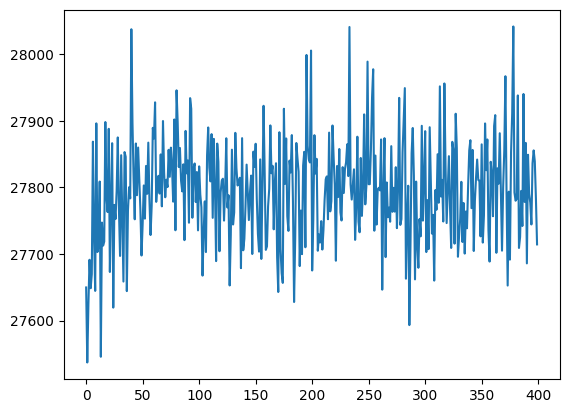

In [23]:
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt


# Genetic Algorithm parameters
pop_size = 150
num_generations = 400
num_genes = 3  # kp, ki, kd
mutation_rate = 0.01


# Search space
kp_space_search = [50, 130]
kd_space_search = [0, 2]
ki_space_search = [50,160]
search_space = [kp_space_search, kd_space_search, ki_space_search]
num_cores = 10

fitness_over_time = []

# Genetic Algorithm
def main():
    global_best_fitness = float(-np.inf)
    best_individual = None
    population = init_population_PID(pop_size, search_space)  # Search space range for each component of PID kp,kd,ki

    for generation in range(num_generations):
        with Pool(num_cores) as pool:
            fitnesses = pool.map(fitnesses_PID, population)


        best = max(fitnesses)
        if best > global_best_fitness:
            global_best_fitness = best
            best_individual = population[fitnesses.index(best)]


        print(f"\n Highest fitness generation:" , best)
        print("\n global_best_fitness and individual: ", global_best_fitness,"\n",best_individual)
        print("\n\nGeneration:", generation)

        fitness_over_time.append(best)

        with open("fitness_data.txt", "a") as f:
                f.write(f"{generation},{best}\n")

        args_list = (population, pop_size, fitnesses, search_space, mutation_rate)
        args_list = [args_list] * pop_size


        #Selection, crossover, and mutation in parallel
        with Pool(num_cores) as pool:
            new_population = pool.map(genetic_algorithm_PID, args_list)

        population = np.array(new_population)

    # Choosing best individual in the end
    print("Best solution:", best_individual, "Fitness:",  global_best_fitness)


if __name__ == '__main__':
    time_start = time.time()
    main()
    time_finish =  time.time() - time_start
    print("Time consumed:", time_finish)
    print("Average time consumed by generation:", time_finish/num_generations)

    plt.plot(fitness_over_time)
    plt.savefig('plot_PID_evolution.png')
    plt.plot()

# Data

In [ ]:
data = np.loadtxt("fitness_data.txt", delimiter=",")
plt.plot(data[:,0], data[:,1])
plt.title('Fitness evolution')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.savefig('plot_PID_evolution.png')
plt.show()